# Prediction of customers' travel pattern

# 1)-Importing key modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
# For processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import datetime as dt
from datetime import datetime
import seaborn as sns
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.figure(figsize=(16,10)) # this creates a figure 16 inch wide, 10 inch high
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# For modeling building and tunning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# for deep learning if I will have time

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [4]:
# for evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
from datetime import date
import datetime as dt

# 2)-Loading data

In [6]:
df_travel = pd.read_csv('travel_data.csv')
df_travel.shape

(47007, 8)

In [7]:
df_travel.columns

Index(['event_type', 'user_id', 'origin', 'destination', 'distance',
       'num_family', 'ts_datetime', 'len_jour'],
      dtype='object')

In [8]:
df_travel.head()

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0
2,book,f953f0,BER,CGN,469.781624,2,2017-04-27 23:03:43,3.0
3,book,794d35,BER,BCN,1498.817537,1,2017-04-27 15:17:50,3.0
4,book,ca4f94,DEL,BKK,2921.339028,4,2017-04-27 22:51:57,6.0


In [9]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df_travel)
table_dtype

,Data Type
num_family,int64
distance,float64
len_jour,float64
event_type,object
user_id,object
origin,object
destination,object
ts_datetime,object


In [10]:
df_travel["ts_datetime"]=pd.to_datetime(df_travel.ts_datetime)

In [11]:
table_dtype = _tbl_dtype(df_travel)
table_dtype

,Data Type
num_family,int64
distance,float64
ts_datetime,datetime64[ns]
len_jour,float64
event_type,object
user_id,object
origin,object
destination,object


# 1)-working with ts_datetime

In [12]:
df_travel['ts_year']=df_travel.ts_datetime.dt.year
df_travel['ts_month']=df_travel.ts_datetime.dt.month
df_travel['ts_day']=df_travel.ts_datetime.dt.day
df_travel['ts_dayofweek']=df_travel.ts_datetime.dt.dayofweek
df_travel['ts_hour']=df_travel.ts_datetime.dt.hour

In [13]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [14]:
df_travel.ts_year.unique()

array([2017])

In [15]:
df_travel.ts_month.unique()

array([4, 5])

**Both month and year will not provide much of longitudnal(time related) information. Only we can see how much booking occured in month of April vs month of May**

In [16]:
len(df_travel[df_travel['ts_month']==4])

42512

In [17]:
len(df_travel[df_travel['ts_month']==5])

4495

In [18]:
df_travel.groupby(df_travel.ts_month).size()

ts_month
4    42512
5     4495
dtype: int64

In [19]:
dist=df_travel.ts_month.value_counts(ascending=True).sort_index()

### 1.1)- Plotting travel pattern

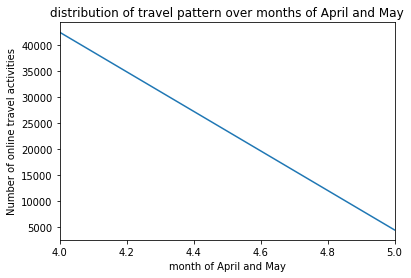

In [20]:
dist.plot()
plt.xlabel('month of April and May')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern over months of April and May')
#plt.legend()
plt.show()

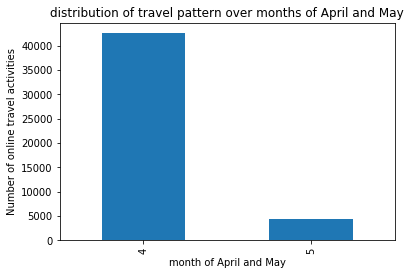

In [21]:
dist.plot(kind="bar")
plt.xlabel('month of April and May')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern over months of April and May')
#plt.legend()
plt.show()

We have not got very useful information there. There is no lineplot that I am used to see for time series.

Let's try other time values

In [22]:
dist2=df_travel.ts_hour.value_counts(ascending=True).sort_index()
dist2

0     3506
1     3009
2     1841
3      918
4      468
5      232
6      124
7       98
8      131
9      294
10     655
11    1240
12    1973
13    2557
14    2758
15    2803
16    2870
17    3059
18    2876
19    2879
20    3053
21    3127
22    3124
23    3412
Name: ts_hour, dtype: int64

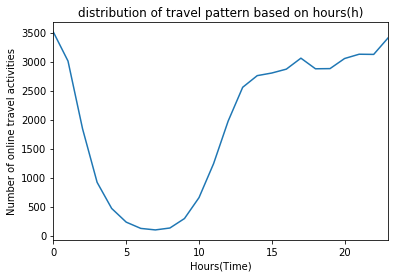

In [23]:
dist2.plot()
plt.xlabel('Hours(Time)')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern based on hours(h)')
#plt.legend()
plt.show()

We can that during morning time i.e 5-10 , there is not much happening. Plot reached its lowest

As we move in working hours , there are more activities. High point approaches after 20:00 i.e 8 pm. This does information about peak and low for online activities. 

It also depends if there is dynamic pricing is in place due to which activities are changing ?

### 1.2)- How does "book" vs "search" go?

In [24]:
t=df_travel

In [25]:
t=t.groupby(["ts_hour","event_type"]).size()
t=t.unstack("event_type")
t

event_type,book,search
ts_hour,,
0,143,3363
1,131,2878
2,88,1753
3,30,888
4,15,453
5,8,224
6,3,121
7,2,96
8,4,127


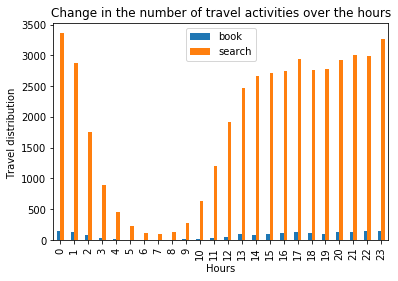

In [26]:
t.plot(kind="bar")
plt.xlabel('Hours')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the hours')
plt.legend()
plt.show()

**Alternative way**

In [27]:
f=df_travel

In [28]:
f=f.groupby(f.ts_hour).event_type.value_counts()

In [29]:
f=f.unstack("event_type")
f

event_type,book,search
ts_hour,,
0,143,3363
1,131,2878
2,88,1753
3,30,888
4,15,453
5,8,224
6,3,121
7,2,96
8,4,127


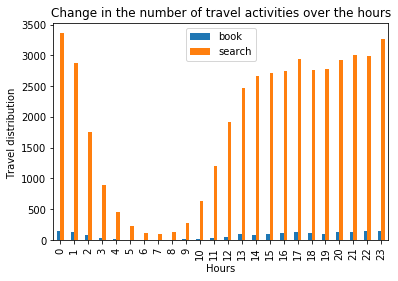

In [30]:
f.plot(kind="bar")
plt.xlabel('Hours')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the hours')
plt.legend()
plt.show()

### 1.3)- By percentage

In [31]:
k=df_travel
k=k.groupby(k.ts_hour).event_type.value_counts(normalize=True)
k=k.unstack("event_type")
k

event_type,book,search
ts_hour,,
0,0.040787,0.959213
1,0.043536,0.956464
2,0.047800,0.952200
3,0.032680,0.967320
4,0.032051,0.967949
5,0.034483,0.965517
6,0.024194,0.975806
7,0.020408,0.979592
8,0.030534,0.969466


### 1.4)- Activities over days of month

In [32]:
q=df_travel

In [33]:
q=q.groupby(["ts_day","event_type"]).size()
q=q.unstack("event_type")
q

event_type,book,search
ts_day,,
1,124,3391
2,38,942
18,90,490
19,121,580
20,103,509
21,151,738
22,128,688
23,133,5787
24,129,3332


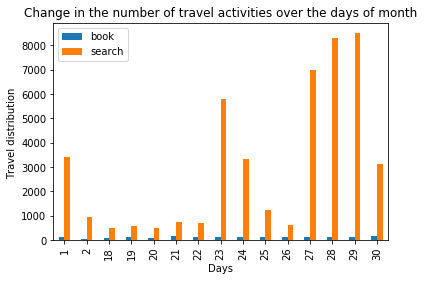

In [34]:
q.plot(kind="bar")
plt.xlabel('Days')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the days of month')
plt.legend()
plt.show()

### 1.5)- Activities over days of week

In [35]:
w=df_travel

In [36]:
w=w.groupby(["ts_dayofweek","event_type"]).size()
w=w.unstack("event_type")
w

event_type,book,search
ts_dayofweek,,
0,253,6723
1,258,2648
2,241,1191
3,208,7496
4,284,9018
5,273,9193
6,292,8929


Increase in search and booking is evident from Day 4-Day 6 i.e Friday-Sunday.

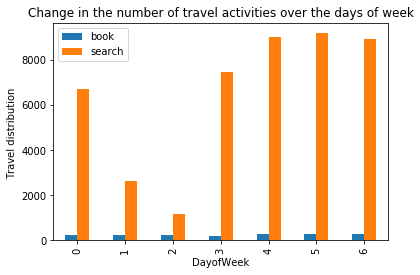

In [37]:
w.plot(kind="bar")
plt.xlabel('DayofWeek')
plt.ylabel('Travel distribution ')
plt.title('Change in the number of travel activities over the days of week')
plt.legend()
plt.show()

### 1.6)- Origin and Destination

Checking what is balance of search and booking on origin and destination

In [38]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [39]:
from collections import Counter
Counter(df_travel.origin)

Counter({'PAR': 6010,
         'FRA': 5813,
         'BER': 3501,
         'DEL': 30,
         'SXF': 254,
         'HAM': 3699,
         'DUS': 4470,
         'DLC': 6,
         'OSL': 26,
         'ORY': 966,
         'CPH': 50,
         'STR': 2684,
         'IZM': 39,
         'AMS': 450,
         'BKK': 165,
         'MOW': 82,
         'NCE': 721,
         'MUC': 4638,
         'LYS': 1560,
         'AGP': 80,
         'PTY': 9,
         'BUH': 42,
         'CGN': 2197,
         'TLS': 985,
         'BOM': 12,
         'CDG': 1306,
         'TXL': 690,
         'SAW': 48,
         'PRG': 84,
         'LON': 162,
         'CHI': 38,
         'SGN': 32,
         'HEL': 21,
         'IST': 169,
         'JFK': 34,
         'NYC': 125,
         'DUB': 52,
         'HAN': 39,
         'MIL': 84,
         'SIN': 108,
         'YEA': 4,
         'ADB': 21,
         'TLV': 73,
         'ATH': 76,
         'SHA': 26,
         'ZRH': 448,
         'ROM': 75,
         'MRS': 896,
         '

In [40]:
Counter(df_travel.destination)

Counter({'NYC': 909,
         'WAS': 67,
         'CGN': 451,
         'BCN': 1513,
         'BKK': 1191,
         'SCL': 49,
         'VIE': 680,
         'ARN': 119,
         'PMI': 2110,
         'LGW': 63,
         'OPO': 1001,
         'ATL': 78,
         'CHI': 68,
         'ATH': 839,
         'BJS': 55,
         'MCO': 66,
         'MUC': 966,
         'MNL': 218,
         'FRA': 681,
         'HNL': 137,
         'YMQ': 282,
         'DXB': 488,
         'HKT': 366,
         'BUE': 67,
         'STR': 491,
         'VCE': 543,
         'NCE': 567,
         'LON': 1101,
         'OSA': 58,
         'IST': 1762,
         'AKL': 114,
         'LIS': 1607,
         'STN': 96,
         'BER': 1468,
         'WAW': 232,
         'MEX': 101,
         'BOS': 84,
         'MOW': 356,
         'IEV': 115,
         'ZRH': 314,
         'GVA': 228,
         'DUS': 772,
         'TYO': 240,
         'AYT': 779,
         'PAR': 1197,
         'LHR': 254,
         'TXL': 322,
         'BUD':

In [41]:
j=df_travel

In [42]:
origin=j.groupby(j.origin).event_type.value_counts(sort=True)
df_origin=pd.DataFrame(origin)
df_origin

event_type
origin event_type            
ABV    search               4
ADB    search              21
ADL    search               3
       book                 1
AER    search               2
...                       ...
YYC    search               9
       book                 1
YYZ    search               6
ZRH    search             430
       book                18

[348 rows x 1 columns]

In [43]:
dest=j.groupby(j.destination).event_type.value_counts(sort=True)
df_dest=pd.DataFrame(dest)
df_dest

event_type
destination event_type            
ABV         search               8
ADB         search             118
            book                 6
ADD         search              39
ADL         search              14
...                            ...
YYC         search              51
            book                 1
YYZ         search              45
ZRH         search             293
            book                21

[445 rows x 1 columns]

This is useful information. But, it is overwhelming. Finding a query for checking specific airport destination

In [44]:
df_nyc=j.groupby([j["destination"]=="NYC"]).event_type.value_counts(sort=True)

In [45]:
nyc=pd.DataFrame(df_nyc)
nyc

event_type
destination event_type            
False       search           44309
            book              1789
True        search             889
            book                20

For Destnation, we have 889 search and 20 booking event at NYC airport

**checking multi-indexing w.r.t destination, hours per day, and event type count**

In [46]:
g=df_travel

In [47]:
g=g.groupby(["destination","ts_hour"]).event_type.value_counts()

In [48]:
df_dest2=pd.DataFrame(g)
df_dest2.head(10)

event_type
destination ts_hour event_type            
ABV         0       search               1
            4       search               2
            14      search               1
            16      search               3
            20      search               1
ADB         0       search               8
            1       search              11
            2       search               6
            3       search               9
            4       search               3

This shows change in activties through different hours at ABV airport. All activities are "search" in ABV case and their count is give as per hours of day.

In [49]:
df_dest2.tail(10)

event_type
destination ts_hour event_type            
ZRH         19      search              23
                    book                 1
            20      search              27
                    book                 2
            21      search              17
                    book                 1
            22      search              24
                    book                 3
            23      search              26
                    book                 1

This gives better information

- This table shows activities occured for ZRH airport destination. At hour 19 i.e 7 pm, we get 23 search queries and 1 booking occured. These kind of tables can help us in viewing how frequent customer choose "ZRH" as their destination and how often they "search" vs "book" for this very destination.

# 4)- Checking duplicates


In [50]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [51]:
dup=df_travel

In [52]:
dup.shape

(47007, 13)

In [53]:
dup.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [54]:
dup.duplicated().sum()

1202

In [55]:
dup.loc[dup.duplicated(), :]

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
152,search,6600e0,FRA,IST,1864.628098,2,2017-04-27 22:39:53,15.0,2017,4,27,3,22
396,search,d84b7f,SIN,DPS,1678.205760,2,2017-04-29 01:42:22,0.0,2017,4,29,5,1
397,search,fd49f2,DUS,ZRH,438.286394,2,2017-04-28 19:48:07,4.0,2017,4,28,4,19
433,search,98617f,STR,VIE,548.651726,2,2017-04-24 00:02:21,2.0,2017,4,24,0,0
481,search,078dff,TXL,PMI,1655.377060,1,2017-04-28 17:55:00,4.0,2017,4,28,4,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46492,search,b6a23c,PAR,VCE,843.229234,2,2017-04-27 20:10:49,2.0,2017,4,27,3,20
46513,search,acbd26,MUC,ATH,1495.104490,1,2017-04-27 04:58:27,8.0,2017,4,27,3,4
46515,search,11a1c2,AYT,STR,2188.445661,2,2017-04-27 13:09:30,0.0,2017,4,27,3,13
46730,search,842398,FRA,BKK,8961.256603,1,2017-04-24 13:07:22,20.0,2017,4,24,0,13


I am not in favor of removing values. But, this seems serious. If we have certain column with duplicate value then I might think a repeating sample such user_id. Same user_id may occur for sure. But, this is for whole 13 columns. This must be fixed.

In [56]:
# using "keep" method in pandas

dup.drop_duplicates(keep="first").shape

(45805, 13)

Original dataset had 47007, 13 and we have now 45805, 13

In [57]:
# make changes in our main dataset.

df_travel.drop_duplicates(keep="first", inplace=True)

In [58]:
df_travel.shape

(45805, 13)

In [59]:
df_travel[df_travel.user_id.duplicated()]

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
41,search,6b4d3b,PAR,MEX,9190.597504,2,2017-04-29 18:05:16,3.0,2017,4,29,5,18
66,book,75ce1b,DUS,BER,477.093351,2,2017-04-29 18:10:50,2.0,2017,4,29,5,18
70,search,6df4fb,DUS,PMI,1334.259311,2,2017-04-29 21:37:51,11.0,2017,4,29,5,21
75,search,eec403,HAM,LHR,745.096782,1,2017-04-29 14:52:31,3.0,2017,4,29,5,14
78,search,53eec8,FRA,TXL,419.301350,1,2017-04-29 13:08:04,2.0,2017,4,29,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46976,search,0ed3a6,CGN,MIL,621.460682,2,2017-04-24 22:15:46,5.0,2017,4,24,0,22
46977,search,2325a1,HAM,VCE,919.655449,2,2017-04-24 19:28:30,2.0,2017,4,24,0,19
47001,search,4153e2,DUS,MUC,485.879102,1,2017-04-28 13:22:45,7.0,2017,4,28,4,13
47002,search,35479c,BER,CDG,856.002808,1,2017-04-28 17:05:43,0.0,2017,4,28,4,17


we have 14626 users that might occur more than once meaning.Let's combine it with event_type variable

In [60]:
df_travel.duplicated(subset=["user_id","event_type"]).sum()

12844

In [61]:
df_travel[df_travel.duplicated(subset=["user_id","event_type"])].head(20)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
41,search,6b4d3b,PAR,MEX,9190.597504,2,2017-04-29 18:05:16,3.0,2017,4,29,5,18
70,search,6df4fb,DUS,PMI,1334.259311,2,2017-04-29 21:37:51,11.0,2017,4,29,5,21
75,search,eec403,HAM,LHR,745.096782,1,2017-04-29 14:52:31,3.0,2017,4,29,5,14
78,search,53eec8,FRA,TXL,419.301350,1,2017-04-29 13:08:04,2.0,2017,4,29,5,13
79,search,53eec8,FRA,TXL,419.301350,1,2017-04-29 14:23:01,2.0,2017,4,29,5,14
80,search,6df4fb,DUS,PMI,1334.259311,2,2017-04-29 20:36:47,11.0,2017,4,29,5,20
99,search,a7abd7,SAW,CGN,2031.120024,1,2017-04-29 22:05:17,0.0,2017,4,29,5,22
124,search,92d3f4,HAM,MAN,808.884731,1,2017-04-24 13:38:31,3.0,2017,4,24,0,13
149,search,1a9909,STR,TXL,509.947989,2,2017-04-27 17:05:49,0.0,2017,4,27,3,17
150,search,24eeb6,PAR,MRS,640.119758,3,2017-04-27 14:49:37,31.0,2017,4,27,3,14


These values might be useful in checking customers' behavior. Some users may not book at 1st search. As we can see at index 78,79 we have user_id 53eec8. In both instances, there is "search". This could be explored in detail to see number of occurances after which some users decide to book. Or do even they book eventually.  

# 5)- Data For Model Buidling

**Drop extra columns**

In [62]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [63]:
df_travel.drop(['user_id', 'ts_year','ts_month','ts_day','ts_dayofweek'], axis=1, inplace=True)

In [64]:
df_travel.shape

(45805, 8)

In [65]:
df_travel.head(2)

,event_type,origin,destination,distance,num_family,ts_datetime,len_jour,ts_hour
0,search,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,11
1,book,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,20


# 6)- Saving data

In [66]:
df_travel.to_csv('model_data.csv',index=False)

**END OF NOTEBOOK2**